In [1]:
import json
from pathlib import Path
import matplotlib as mpl
import tikzplotlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from rich.progress import track
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import RocCurveDisplay, f1_score
from sklearn.preprocessing import MaxAbsScaler

In [2]:
def parse_files(root_path):
    """
    Parse files and use pd.json_normalize to flatten the json.
    """
    files = root_path.joinpath("train-output-all-features").glob("**/*.json")
    results = pd.DataFrame()
    files = list(files)

    for file in track(
        files,
        description="Loading hyperparameters and "
        "performance data from file to DataFrame",
    ):
        with open(file) as f:
            data = json.load(f)
            original_target = root_path.joinpath(data["original_target"])
            original_dict = json.loads(Path(original_target).read_text())

            f1_scores = pd.json_normalize(data, "f1_scores")
            normalized_data = pd.json_normalize(original_dict)
            normalized_data = pd.concat(
                [normalized_data] * len(f1_scores), ignore_index=True
            )
            normalized_data["metrics.f1_score"] = f1_scores
            normalized_data["paths.model_path"] = data["model_path"]
            results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

    results = results.set_index(
        ["percentage", "model", "use_gradient", "use_ewma"]
    )
    results.columns = pd.MultiIndex.from_arrays(
        zip(*results.columns.str.split(".", expand=True))
    )
    results = results.sort_index(axis=1)
    results = results.drop(columns=['k_fold', 'preprocessing'])
    results = results.droplevel(0, axis=1)

    return results


data_flattened = parse_files(Path("./analysis/"))
data_flattened

Output()

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_50509/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

C  alpha hidden_layer_sizes kernel  \
percentage model use_gradient use_ewma                                         
4          SVM   True         False     1.0    NaN                NaN    rbf   
                              False     1.0    NaN                NaN    rbf   
                              False     1.0    NaN                NaN    rbf   
                              False     1.0    NaN                NaN    rbf   
                              False     1.0    NaN                NaN    rbf   
...                                     ...    ...                ...    ...   
19         LR    False        False     1.0    NaN                NaN    NaN   
                              False     1.0    NaN                NaN    NaN   
                              False     1.0    NaN                NaN    NaN   
                              False     1.0    NaN                NaN    NaN   
                              False     1.0    NaN                NaN    NaN   

                                        learning_rate  max_depth  \
percentage model use_gradient use_ewma                             
4          SVM   True         False               NaN        NaN   
                              False               NaN        NaN   
                              False               NaN        NaN   
                              False               NaN        NaN   
                              False               NaN        NaN   
...                                               ...        ...   
19         LR    False        False               NaN        NaN   
                              False               NaN        NaN   
                              False               NaN        NaN   
                              False               NaN        NaN   
                              False               NaN        NaN   

                                        n_estimators  f1_score  \
percentage model use_gradient use_ewma                           
4          SVM   True         False              NaN  0.717391   
                              False              NaN  0.708333   
                              False              NaN  0.717391   
                              False              NaN  0.691589   
                              False              NaN  0.736842   
...                                              ...       ...   
19         LR    False        False              NaN  0.627451   
                              False              NaN  0.576923   
                              False              NaN  0.685714   
                              False              NaN  0.416667   
                              False              NaN  0.478261   

                                                                               model_path  
percentage model use_gradient use_ewma                                                     
4          SVM   True         False     train-output-all-features/SVM_4_grad_no-ewma_3...  
                              False     train-output-all-features/SVM_4_grad_no-ewma_3...  
                              False     train-output-all-features/SVM_4_grad_no-ewma_3...  
                              False     train-output-all-features/SVM_4_grad_no-ewma_3...  
                              False     train-output-all-features/SVM_4_grad_no-ewma_3...  
...                                                                                   ...  
19         LR    False        False     train-output-all-features/LR_19_no-grad_no-ewm...  
                              False     train-output-all-features/LR_19_no-grad_no-ewm...  
                              False     train-output-all-features/LR_19_no-grad_no-ewm...  
                              False     train-output-all-features/LR_19_no-grad_no-ewm...  
                              False     train-output-all-features/LR_19_no-grad_no-ewm...  

[33540 rows x 9 columns]

In [3]:
# Remove any runs that included use_ewma or use_gradient
df = data_flattened.loc[(slice(None), slice(None), False, False), :]
df.index = df.index.droplevel([2, 3])
df = df.sort_values(by=['percentage', 'model'])
df

C  alpha hidden_layer_sizes  kernel  learning_rate  \
percentage model                                                            
1          AdaBoost  NaN    NaN                NaN     NaN            0.1   
           AdaBoost  NaN    NaN                NaN     NaN            0.1   
           AdaBoost  NaN    NaN                NaN     NaN            0.1   
           AdaBoost  NaN    NaN                NaN     NaN            0.1   
           AdaBoost  NaN    NaN                NaN     NaN            0.1   
...                  ...    ...                ...     ...            ...   
20         SVM       0.1    NaN                NaN  linear            NaN   
           SVM       0.1    NaN                NaN  linear            NaN   
           SVM       0.1    NaN                NaN  linear            NaN   
           SVM       0.1    NaN                NaN  linear            NaN   
           SVM       0.1    NaN                NaN  linear            NaN   

                     max_depth  n_estimators  f1_score  \
percentage model                                         
1          AdaBoost        NaN          50.0  0.737705   
           AdaBoost        NaN          50.0  0.710744   
           AdaBoost        NaN          50.0  0.861538   
           AdaBoost        NaN          50.0  0.761062   
           AdaBoost        NaN          50.0  0.794118   
...                        ...           ...       ...   
20         SVM             NaN           NaN  0.468085   
           SVM             NaN           NaN  0.625000   
           SVM             NaN           NaN  0.428571   
           SVM             NaN           NaN  0.489796   
           SVM             NaN           NaN  0.541667   

                                                            model_path  
percentage model                                                        
1          AdaBoost  train-output-all-features/AdaBoost_1_no-grad_n...  
           AdaBoost  train-output-all-features/AdaBoost_1_no-grad_n...  
           AdaBoost  train-output-all-features/AdaBoost_1_no-grad_n...  
           AdaBoost  train-output-all-features/AdaBoost_1_no-grad_n...  
           AdaBoost  train-output-all-features/AdaBoost_1_no-grad_n...  
...                                                                ...  
20         SVM       train-output-all-features/SVM_20_no-grad_no-ew...  
           SVM       train-output-all-features/SVM_20_no-grad_no-ew...  
           SVM       train-output-all-features/SVM_20_no-grad_no-ew...  
           SVM       train-output-all-features/SVM_20_no-grad_no-ew...  
           SVM       train-output-all-features/SVM_20_no-grad_no-ew...  

[8600 rows x 9 columns]

In [4]:
def float_or_list_to_tuple(x):
    if isinstance(x, list):
        return tuple(x)
    return x

df["hidden_layer_sizes"] = df['hidden_layer_sizes'].apply(float_or_list_to_tuple)

In [5]:
group = df.groupby(['percentage', 'model', 'C', 'hidden_layer_sizes', 'kernel', 'learning_rate', 'max_depth', 'n_estimators', 'alpha'], dropna=False)
summary = group['f1_score'].agg(['mean', 'std'])

idx = summary.groupby(['percentage', 'model']).idxmax()

best_hyperparams = summary.loc[idx['mean'], :]
best_per_percentage = best_hyperparams.groupby('percentage')['mean'].idxmax()
selected_percentages = best_hyperparams[best_hyperparams.index.get_level_values('percentage').isin([5, 10, 15, 20]) & best_hyperparams.index.get_level_values('model').isin(['RF', 'ET'])]
models_to_test = selected_percentages.droplevel(['C', 'hidden_layer_sizes', 'kernel', 'learning_rate', 'alpha'])
models_to_test


mean       std
percentage model max_depth n_estimators                    
5          ET    NaN       50.0          0.847029  0.045612
           RF    NaN       200.0         0.853927  0.049522
10         ET    NaN       100.0         0.802062  0.079222
           RF    10.0      200.0         0.800509  0.072289
15         ET    20.0      200.0         0.736083  0.089609
           RF    10.0      100.0         0.733167  0.065382
20         ET    20.0      200.0         0.722869  0.114308
           RF    10.0      200.0         0.718031  0.052831

In [6]:
random_state = 42
classifiers = {}
for percentage, model, max_depth, n_estimators in models_to_test.index:
    if np.isnan(max_depth):
        max_depth = None
    else:
        max_depth = int(max_depth)
    n_estimators = int(n_estimators)
    if model == 'ET':
        classifiers[(percentage, model)] = ExtraTreesClassifier(max_depth=max_depth, n_estimators=n_estimators, random_state=random_state, class_weight='balanced')
    elif model == 'RF':
        classifiers[(percentage, model)] = RandomForestClassifier(max_depth=max_depth, n_estimators=n_estimators, random_state=random_state, class_weight='balanced_subsample')
    classifiers[(percentage, 'Dum')] = DummyClassifier(strategy='stratified', random_state=random_state)
classifiers

{(5,
  'ET'): ExtraTreesClassifier(class_weight='balanced', n_estimators=50, random_state=42),
 (5, 'Dum'): DummyClassifier(random_state=42, strategy='stratified'),
 (5,
  'RF'): RandomForestClassifier(class_weight='balanced_subsample', n_estimators=200,
                        random_state=42),
 (10, 'ET'): ExtraTreesClassifier(class_weight='balanced', random_state=42),
 (10, 'Dum'): DummyClassifier(random_state=42, strategy='stratified'),
 (10,
  'RF'): RandomForestClassifier(class_weight='balanced_subsample', max_depth=10,
                        n_estimators=200, random_state=42),
 (15,
  'ET'): ExtraTreesClassifier(class_weight='balanced', max_depth=20, n_estimators=200,
                      random_state=42),
 (15, 'Dum'): DummyClassifier(random_state=42, strategy='stratified'),
 (15,
  'RF'): RandomForestClassifier(class_weight='balanced_subsample', max_depth=10,
                        random_state=42),
 (20,
  'ET'): ExtraTreesClassifier(class_weight='balanced', max_depth=20, 

In [7]:
import pickle

def preprocess(dataframe, scaler=None):
    result, mzn = dataframe.drop(columns=['mzn', 'dzn'], axis=1), dataframe['mzn']

    # Drop any columns that contain the text 'ewma' or 'gradient'
    result = result.drop(columns=result.columns[result.columns.str.contains('ewma|gradient')], axis=1)

    result = result.drop(result.columns[result.nunique() == 1], axis=1)

    if scaler is None:
        scaler = MaxAbsScaler().fit(result)
    result = pd.DataFrame(scaler.transform(result), columns=result.columns, index=result.index)

    result['mzn'] = mzn

    return result, scaler

scalers = {}

train_pkl = Path('./analysis/rerun_with_all_features_train.pkl')

with open(train_pkl, 'rb') as f:
    train_features_at_percentage = pickle.load(f)

for perc in train_features_at_percentage:
    train_features_at_percentage[perc] = train_features_at_percentage[perc]

for percentage, model in classifiers:
    print(f"Training {model} at {percentage}%")
    df, scaler = preprocess(train_features_at_percentage[percentage])
    scalers[(percentage, model)] = scaler
    df = df.drop(columns=['mzn'], axis=1)
    any_nan = df.isna().any().any()
    
    if any_nan:
        print("The NaN values are in the following columns:")
        print(df.columns[df.isna().any()])
    else:
        train_X, train_y = df.drop(columns=['solved_within_time_limit']), df['solved_within_time_limit']
        classifiers[(percentage, model)].fit(train_X, train_y)


Training ET at 5%
Training Dum at 5%
Training RF at 5%
Training ET at 10%
Training Dum at 10%
Training RF at 10%
Training ET at 15%
Training Dum at 15%
Training RF at 15%
Training ET at 20%
Training Dum at 20%
Training RF at 20%


In [8]:
describe_features = pd.DataFrame({'feature': preprocess(train_features_at_percentage[1])[0].drop(['mzn', 'solved_within_time_limit'], axis=1).columns})
describe_features['description'] = [
    "Number of conflicts",
    "Number of decisions made/nodes",
    "Number of search iterations completed",
    "??? (number of assigned nodes or variables)",
    "Number of variables",
    "Number of backjumps",
    "Number of solutions found",
    "Total time spent",
    "Time spent searching",
    "Number of integer variables",
    "Number of propagations",
    "Number of SAT propagations",
    "Number of propagators",
    "Number of boolean variables",
    "Number of learnt clauses",
    "Number of binary clauses",
    "Number of ternary clauses",
    "Number of clauses longer than 3",
    "The maximum decision level reached",
    "Current decision level of the engine",
    "Size of the tree of the decision level",
    "Amount of memory used by clauses",
    "Amount of memory used by propagators",
    "Ratio of failures/conflicts to unassigned variables",
    "Ratio of visited nodes to open nodes",
    "Fraction of variables that are boolean",
    "Ratio of propagations to variables",
    "Fraction of clauses that are longer than 3",
    "How often the engine backtracks (backjumps / total search time)",
]
describe_features['translated'] = [
    False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, True, False, False, False, True
]
describe_features

,feature,description,translated
0,conflicts,Number of conflicts,False
1,decisions,Number of decisions made/nodes,False
2,search_iterations,Number of search iterations completed,False
3,opennodes,??? (number of assigned nodes or variables),False
4,vars,Number of variables,False
5,back_jumps,Number of backjumps,False
6,solutions,Number of solutions found,False
7,total_time,Total time spent,False
8,search_time,Time spent searching,False
9,intVars,Number of integer variables,False


In [9]:
describe_features.columns.str.capitalize()

Index(['Feature', 'Description', 'Translated'], dtype='object')

Testing ET at 5%
F1 score for ET at 5%: 0.84
Testing RF at 5%
F1 score for RF at 5%: 0.87
Testing Dum at 5%
F1 score for Dum at 5%: 0.44
Testing ET at 10%
F1 score for ET at 10%: 0.70
Testing RF at 10%
F1 score for RF at 10%: 0.73
Testing Dum at 10%
F1 score for Dum at 10%: 0.28
Testing ET at 15%
F1 score for ET at 15%: 0.71
Testing RF at 15%
F1 score for RF at 15%: 0.76
Testing Dum at 15%
F1 score for Dum at 15%: 0.14
Testing ET at 20%
F1 score for ET at 20%: 0.74
Testing RF at 20%
F1 score for RF at 20%: 0.72
Testing Dum at 20%
F1 score for Dum at 20%: 0.22


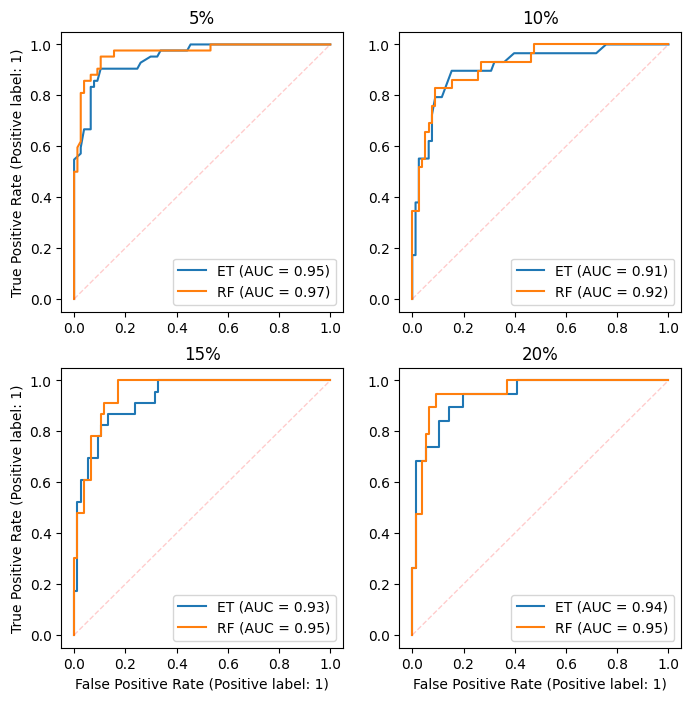

In [10]:
test_pickle = Path('./analysis/rerun_with_all_features_test.pkl')

with open(test_pickle, 'rb') as f:
    test_features_at_percentage = pickle.load(f)

for perc in test_features_at_percentage:
    test_features_at_percentage[perc] = test_features_at_percentage[perc]

plots = {}
# Create a figure and axes with 4 subplots
fig, ax = plt.subplots(2, 2, figsize=(8, 8))
ax = ax.flatten()

scores = []

for i, percentage in enumerate([5, 10, 15, 20]):
    for model in ['ET', 'RF', 'Dum']:
        print(f"Testing {model} at {percentage}%")
        scaler = scalers[(percentage, model)]
        df, _ = preprocess(test_features_at_percentage[percentage], scaler)
        df = df.drop(columns=['mzn'], axis=1)
        
        test_X, test_y = df.drop(columns=['solved_within_time_limit']), df['solved_within_time_limit']
        
        y_score = classifiers[(percentage, model)].predict_proba(test_X)[:, 1]
        if model != 'Dum':
            plots[(percentage, model)] = RocCurveDisplay.from_predictions(test_y, y_score, ax=ax[i], name=model)
        
            if percentage in [5, 10]:
                ax[i].set_xlabel('')
            if percentage in [10, 20]:
                ax[i].set_ylabel('')

        score = f1_score(test_y, classifiers[(percentage, model)].predict(test_X))
        scores.append([percentage, model, score])
        print(f"F1 score for {model} at {percentage}%: {score:.2f}")

    ax[i].set_title(f"{percentage}%")
    ax[i].plot([0, 1], [0, 1], linestyle='--', lw=1, color='r', alpha=.2)

tikzplotlib.clean_figure()
tikzplotlib.save("roc_curves.tex", axis_width="0.55\\textwidth", axis_height="0.55\\textwidth")

<AxesSubplot:>

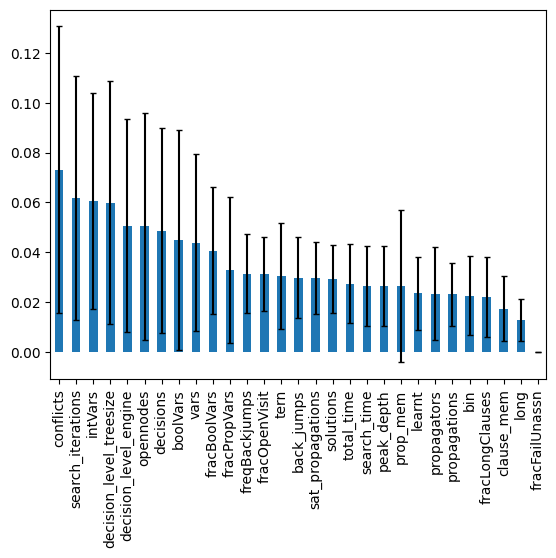

In [11]:
def get_importances(percentage, model, classifiers):
    model = classifiers[(percentage, model)]
    importance = model.feature_importances_
    std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
    return pd.DataFrame({'mean': importance, 'std': std}, index=model.feature_names_in_)

importance = get_importances(20, 'ET', classifiers).sort_values(by='mean', ascending=False)
importance['mean'].plot.bar(yerr=importance['std'], capsize=2)

# plt.barh(m.index, m['importance'], xerr=s['std'], capsize=2)
# rf_importances = pd.DataFrame([get_importances(x, c, classifiers) for x in [5, 10, 15, 20] for c in ['RF']], index=[5, 10, 15, 20])
# et_importances = pd.DataFrame([get_importances(x, c, classifiers) for x in [5, 10, 15, 20] for c in ['ET']], index=[5, 10, 15, 20])

In [12]:
score_df = pd.DataFrame(scores, columns=['Percentage', 'Model', 'F1 score'])#.set_index(['Percentage', 'Model']).unstack()
score_df = score_df.set_index(['Percentage', 'Model']).unstack()
score_df.index = score_df.index.astype(str)+"%"
score_df.style.highlight_max(axis=1, props="font-weight:bold;")

In [13]:
(score_df.round(3)
    .style.format_index(escape='latex')
    .format(precision=2)
    .highlight_max(axis=1, props="textbf:--rwrap;")
    .to_latex(
        "f1-table.tex",
        hrules=True,
        multicol_align='c',
        caption="F1 scores for each model at selected \% of TL.",
        label="tab:f1-scores",
        position_float="centering")
)

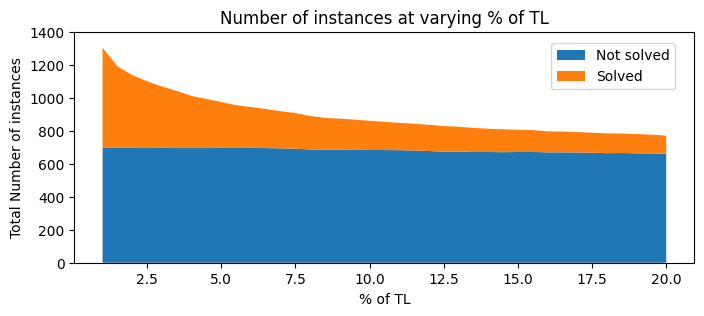

In [14]:
n_total = np.array([train_features_at_percentage[i].shape[0] for i in range(1, len(train_features_at_percentage) + 1)])
n_solved = np.array([train_features_at_percentage[i]['solved_within_time_limit'].sum() for i in range(1, len(train_features_at_percentage) + 1)])
n_not_solved = np.array([n_total[i] - n_solved[i] for i in range(len(n_total))])
percentage_solved = np.array([n_solved[i] / n_total[i] for i in range(len(n_total))]) * 100

x = np.arange(1, 20.5, 0.5)

fig, ax = plt.subplots(figsize=(8, 3))
stacks = ax.stackplot(x, n_not_solved, n_solved, labels=['Not solved', 'Solved'])
ax.set_title("Number of instances at varying % of TL")
ax.set_xlabel("% of TL")
ax.set_ylabel("Total Number of instances")
ax.set_ylim([0, 1400])
ax.legend(loc='upper right', bbox_to_anchor=(0.98, 0.98))

# fig.legend(loc='upper right', bbox_to_anchor=(0.88, 0.88))
# fig.tight_layout()
# plt.savefig("class_balance_over_time.pgf", backend="pgf")
# tikzplotlib.clean_figure()
tikzplotlib.save("class_balance_over_time.tex", axis_width="0.9\\textwidth", axis_height="0.4\\textwidth")

In [44]:
all_features = {i: pd.concat([train_features_at_percentage[i], test_features_at_percentage[i]]) for i in range(1, len(train_features_at_percentage) + 1)}
all_features[1]

,conflicts,ewma_conflicts,decisions,search_iterations,opennodes,ewma_opennodes,vars,back_jumps,ewma_back_jumps,solutions,...,fracOpenVisit,fracBoolVars,fracPropVars,frac_unassigned,fracLongClauses,freqBackjumps,mzn,dzn,solved_within_time_limit,has_gradients
1171,8803,8784.0,11197,20001,3088703,3088703.50,3090204,891,0.05,0,...,0.000486,0.833344,3.691990,1.0,0,24.717299,2DPacking.mzn,Class7_100_8.dzn,False,False
638,91874,91855.0,110223,201798,1703,1703.31,1715,18246,0.12,3,...,0.007046,0.923615,2948.814577,1.0,441,506.925397,still_life_free.mzn,7x7.dzn,True,False
931,11623,11604.0,192877,204501,169010,169015.28,169028,181234,21.00,0,...,0.000107,0.996036,24.709220,1.0,3597,5033.713722,wwtpp.mzn,ex05200_2600_100.dzn,True,False
258,78777,78758.0,81520,20,75046,75011.64,75053,13,0.00,303,...,0.000093,0.998867,242.995110,1.0,0,0.360887,city-position.mzn,city-5-06.dzn,False,False
1182,37362,37343.0,98212,9372,37725,37725.63,37734,59721,0.00,26,...,0.000239,0.945540,2057.901654,1.0,8886,1660.024595,ProjectPlannertest_16_7.mzn,NO-MODEL-FILE.dzn,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1069,50483,50464.0,50515,100886,49259,49245.98,49262,20,0.00,2,...,0.000061,0.979274,414.697130,1.0,0,0.555507,ship-schedule.mip.mzn,4ShipsMixed.dzn,True,False
397,65478,65459.0,68422,133901,205853,205855.02,206484,2313,0.24,0,...,0.003065,0.833396,48.401629,1.0,0,64.229361,2DPacking.mzn,Class6_40_8.dzn,True,False
250,61218,61199.0,66523,72398,57425,57425.10,57509,47,0.00,59,...,0.001463,0.894956,57.105253,1.0,25871,1.305005,model.mzn,data3_4_31.dzn,False,False
171,1544,1525.0,1745,549,307882,307371.31,307913,5,0.00,11,...,0.000101,0.999425,11.185802,1.0,22562,0.290810,tdtsp.mzn,inst_10_58_20.dzn,True,False


In [18]:
import glob
import enum

class ProblemType(enum.Enum):
    UNKNOWN = 0
    SAT = 1
    OPT = 2

fzn_files = list(glob.glob(f"analysis/problems_compiled/*.fzn"))
summary = []


for fzn_file in track(fzn_files, description="Counting SAT/OPT"):
    with open(fzn_file, "r") as f:
        contents = f.read()
        problem_type = None
        if "satisfy" in contents:
            problem_type = ProblemType.SAT
        elif "minimize" in contents or "maximize" in contents:
            problem_type = ProblemType.OPT
        else:
            problem_type = ProblemType.UNKNOWN
        
        summary.append({
            "Problem": fzn_file,
            "Problem Type": problem_type
        })

summary_df = pd.DataFrame(summary, dtype=str)

Output()

In [113]:
regex_str = r'analysis/problems_compiled/.+MZN-(.+)-DZN.+\.fzn'
all_mzn = summary_df['Problem'].str.extract(regex_str, expand=False) + '.mzn'
summary_df['mzn'] = all_mzn
regex_str = r'analysis/problems_compiled/.+DZN-(.+)\.fzn'
all_dzn = summary_df['Problem'].str.extract(regex_str, expand=False) + '.dzn'
summary_df['dzn'] = all_dzn
summary_df

past_n_percent = []

for i in track(range(1, len(all_features) + 1), description="Counting problems that ran past n\% of TL"):

half_percent_feautures = all_features[1]

summary_df['Past Half Percent'] = summary_df[['mzn', 'dzn']].apply(tuple, axis=1).isin(half_percent_feautures[['mzn', 'dzn']].apply(tuple, axis=1))
summary_past = summary_df[summary_df['Past Half Percent']]
summary_past

summary_df.groupby(['Problem Type', 'Past Half Percent']).count().drop(columns=['mzn', 'dzn'])

Problem
Problem Type    Past Half Percent         
ProblemType.OPT False                14017
                True                  1157
ProblemType.SAT False                 1518
                True                   294